In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

## Loading Data


In [74]:
df = pd.read_csv("dataset_transfer2.csv")

## Embeddings creation
model = all-mpnet-base-v2

In [75]:
model = SentenceTransformer('all-mpnet-base-v2')
texts = df["text"].tolist()
embeddings = model.encode(texts, show_progress_bar=True)

Batches: 100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


## KMeans clustering
2 literature styles: Beat Generation and XIX-century

In [76]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)
df["cluster"] = cluster_labels

## Silhouette Score

In [77]:
# original + transfer texts
sil_all = silhouette_score(embeddings, cluster_labels)
print(f"Silhouette Score (ALL, k={n_clusters}): {sil_all:.3f}")

# for only original texts
mask_orig = df["transfer_type"] == "ORIGINAL"
embeddings_orig = embeddings[mask_orig.values]
labels_orig = cluster_labels[mask_orig.values]

if len(set(labels_orig)) >= 2:
    sil_orig = silhouette_score(embeddings_orig, labels_orig)
    print(f"Silhouette Score (ORIGINALS only): {sil_orig:.3f}")
else:
    print("Not enough clusters in ORIGINALS to compute Silhouette Score.")


Silhouette Score (ALL, k=2): 0.120
Silhouette Score (ORIGINALS only): 0.135


## Reduction to 2D
### (UMAP, PCA, t-SNE Comparison)

C:\Users\mdomi\PycharmProjects\NLP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


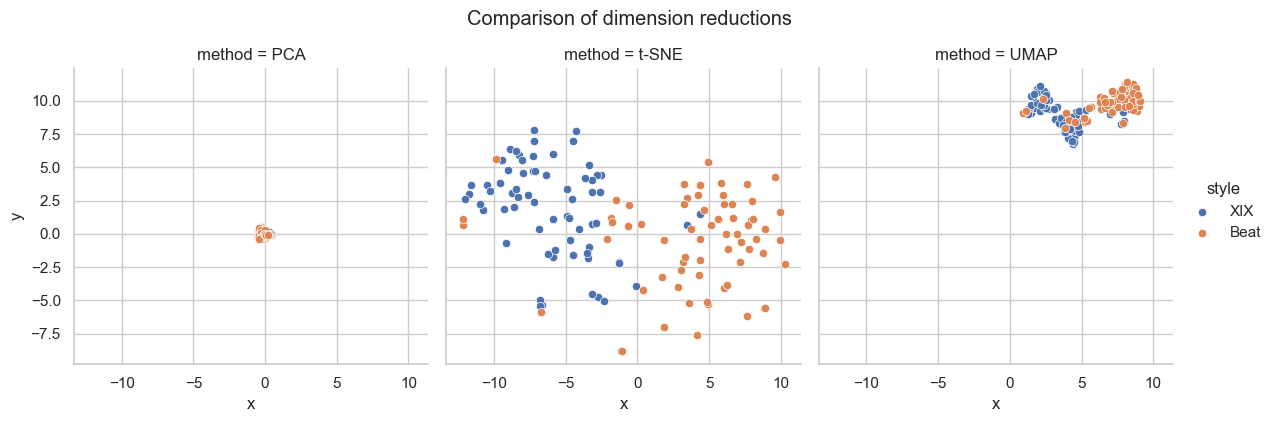

In [78]:
# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
reduced = reducer.fit_transform(embeddings)
# PCA
reduced_pca = PCA(n_components=2).fit_transform(embeddings)
# t-SNE
reduced_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embeddings)

df_pca = pd.DataFrame(reduced_pca, columns=["x", "y"])
df_pca["style"] = df["style"]
df_pca["method"] = "PCA"

df_tsne = pd.DataFrame(reduced_tsne, columns=["x", "y"])
df_tsne["style"] = df["style"]
df_tsne["method"] = "t-SNE"

df_umap = pd.DataFrame(reduced, columns=["x", "y"])
df_umap["style"] = df["style"]
df_umap["method"] = "UMAP"

df_combined = pd.concat([df_pca, df_tsne, df_umap])

sns.set(style="whitegrid")
g = sns.FacetGrid(df_combined, col="method", hue="style", height=4, aspect=1)
g.map_dataframe(sns.scatterplot, x="x", y="y")
g.add_legend()
plt.suptitle("Comparison of dimension reductions", y=1.05)
plt.show()

## Data preparation ##

In [79]:
df_vis = pd.DataFrame(reduced, columns=["x", "y"])
df_vis["author"] = df["author"]
df_vis["style"] = df["style"]
df_vis["cluster"] = df["cluster"]
df_vis["transfer_type"] = df["transfer_type"]

## Interpolation ##

In [80]:
centroid_XIX = embeddings[df["style"] == "XIX"].mean(axis=0)
centroid_Beat = embeddings[df["style"] == "Beat"].mean(axis=0)

# generation of interpolation points
interpolated_embeddings = []
interpolated_labels = []

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
for alpha in alphas:
    interp = (1 - alpha) * centroid_XIX + alpha * centroid_Beat
    interpolated_embeddings.append(interp)
    interpolated_labels.append(f"INTERP_{alpha:.2f}")

# adding interopolation to UMAP
interp_2d = reducer.transform(interpolated_embeddings)
df_interp = pd.DataFrame(interp_2d, columns=["x", "y"])
df_interp["author"] = interpolated_labels
df_interp["style"] = "INTERPOLATION"
df_interp["cluster"] = -1

# merging with df_vis
df_vis = pd.concat([df_vis, df_interp], ignore_index=True)

# alpha sortiong inter points
df_interp_sorted = df_vis[df_vis["style"] == "INTERPOLATION"].copy()
df_interp_sorted["alpha"] = df_interp_sorted["author"].str.extract(r'INTERP_(\d\.\d+)').astype(float)
df_interp_sorted = df_interp_sorted.sort_values("alpha")

C:\Users\mdomi\PycharmProjects\NLP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Interpolation literary style plot ##

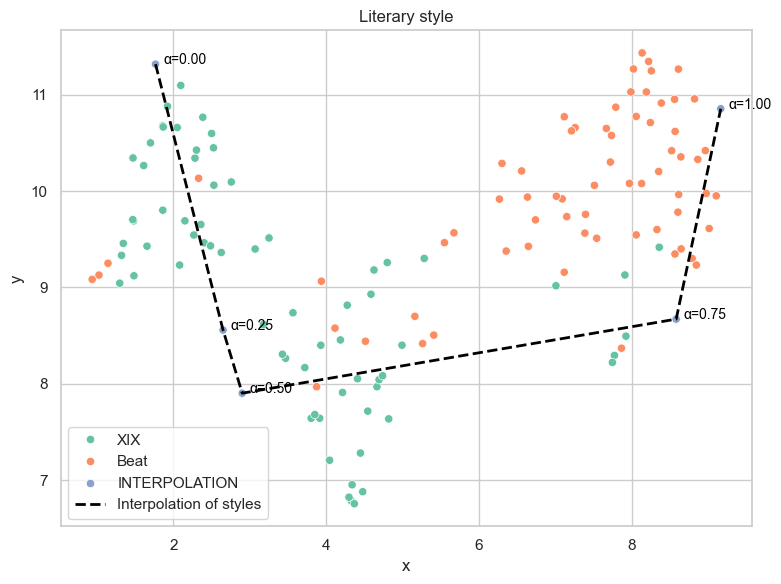

In [81]:

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_vis, x="x", y="y", hue="style", palette="Set2")
plt.title("Literary style")

plt.plot(df_interp_sorted["x"], df_interp_sorted["y"], color="black", linestyle="--", linewidth=2, label="Interpolation of styles")

# adding labels
for i, row in df_interp_sorted.iterrows():
    label = row["author"].replace("INTERP_", "α=")
    plt.text(row["x"] + 0.1, row["y"], label, fontsize=10, color="black")

plt.tight_layout()
plt.legend()
plt.show()


## Transfers and original texts plot ##

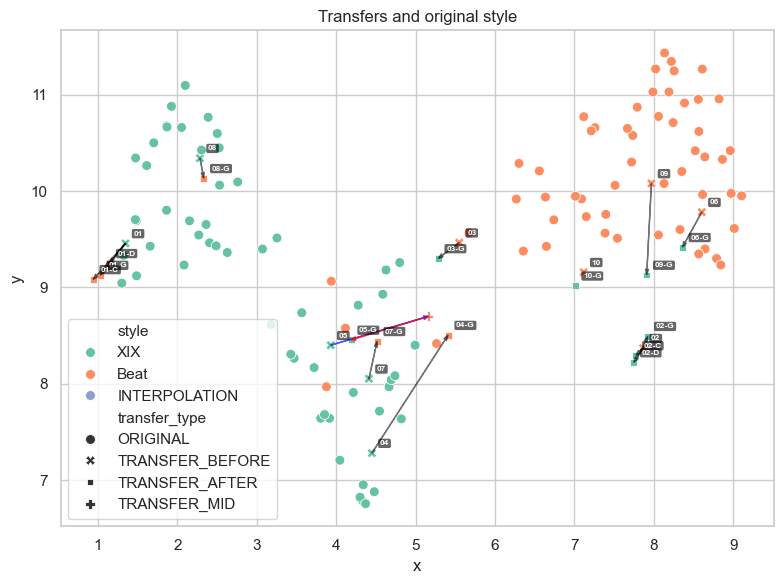

In [82]:
plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_vis, x="x", y="y", hue="style", style="transfer_type", s=50, palette="Set2")

# arrows: TRANSFER_BEFORE -> MID -> AFTER
for model in ["GPT", "CLD", "DPS"]:
    mid_authors = df_vis["author"].unique()
    mid_ids = sorted(set(
        a.split("_")[2]
        for a in mid_authors
        if a.startswith("TRANSFER_MID_") and model in a
    ))

    for transfer_id in mid_ids:
        mid = f"TRANSFER_MID_{transfer_id}_{model}"
        before = f"TRANSFER_BEFORE_{transfer_id}"
        after  = f"TRANSFER_AFTER_{transfer_id}_{model}"

        if not df_vis[df_vis["author"] == mid].empty:
            mid_point = df_vis[df_vis["author"] == mid].iloc[0]

            if not df_vis[df_vis["author"] == before].empty:
                before_point = df_vis[df_vis["author"] == before].iloc[0]
                plt.arrow(
                    before_point["x"], before_point["y"],
                    mid_point["x"] - before_point["x"],
                    mid_point["y"] - before_point["y"],
                    color="blue", width=0.002, head_width=0.04,
                    alpha=0.6, length_includes_head=True
                )

            if not df_vis[df_vis["author"] == after].empty:
                after_point = df_vis[df_vis["author"] == after].iloc[0]
                plt.arrow(
                    mid_point["x"], mid_point["y"],
                    after_point["x"] - mid_point["x"],
                    after_point["y"] - mid_point["y"],
                    color="red", width=0.002, head_width=0.04,
                    alpha=0.6, length_includes_head=True
                )

# direct arrows
for model in ["GPT", "CLD", "DPS"]:
    for transfer_id in range(1, 10):
        mid = f"TRANSFER_MID_0{transfer_id}_{model}"
        if mid in df_vis["author"].values:
            continue

        before = f"TRANSFER_BEFORE_0{transfer_id}"
        after = f"TRANSFER_AFTER_0{transfer_id}_{model}"

        if not df_vis[df_vis["author"] == before].empty and not df_vis[df_vis["author"] == after].empty:
            before_point = df_vis[df_vis["author"] == before].iloc[0]
            after_point = df_vis[df_vis["author"] == after].iloc[0]
            plt.arrow(
                before_point["x"], before_point["y"],
                after_point["x"] - before_point["x"],
                after_point["y"] - before_point["y"],
                color="black", width=0.002, head_width=0.04,
                alpha=0.5, length_includes_head=True
            )

# labels
for i, row in df_vis.iterrows():
    author = row["author"]
    if author.startswith("TRANSFER_BEFORE_") or author.startswith("TRANSFER_AFTER_"):
        parts = author.split("_")
        transfer_num = parts[2] if len(parts) > 2 else ""
        if "AFTER" in author and len(parts) > 3:
            transfer_num += f"-{parts[3][0]}"  # adding LLM label: GPT = G etc
        plt.text(
            row["x"] + 0.1,
            row["y"] + 0.08,
            transfer_num,
            fontsize=6,
            color="white",
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.2", fc="black", ec="none", alpha=0.6)
        )

plt.title("Transfers and original style")
plt.legend()
plt.tight_layout()
plt.show()


## style Convex Hull plot ##

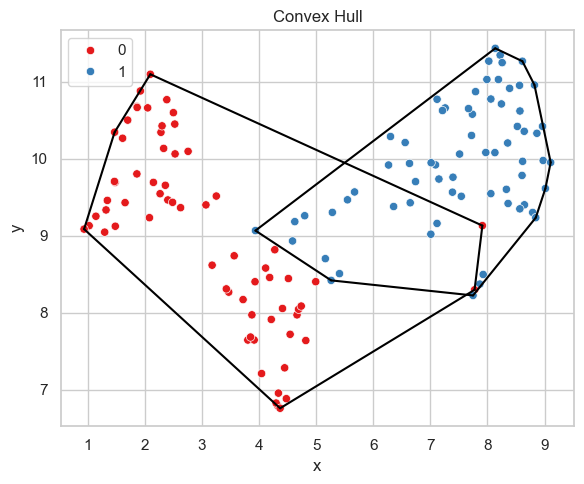

In [83]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(
    data=df_vis[df_vis["cluster"] != -1], # skip interpolation points
    x="x", y="y", hue="cluster", palette="Set1", ax=ax
)


for cluster_id in df_vis["cluster"].unique():
    if cluster_id == -1:
        continue
    points = df_vis[df_vis["cluster"] == cluster_id][["x", "y"]].values
    if len(points) >= 3:
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], color="black", linewidth=1.5)

plt.title("Convex Hull")
plt.legend()
plt.tight_layout()
plt.show()


## Style classifier ##

In [84]:
X_orig = embeddings[df["transfer_type"] == "ORIGINAL"]
y_orig = df[df["transfer_type"] == "ORIGINAL"]["style"]

X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, random_state=42)
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("\n Accuracy [original texts]:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# prediction of style of GPT models
mask = df["author"].str.startswith("TRANSFER_AFTER_") & df["author"].str.endswith("_GPT")
X_transfer = embeddings[mask]
y_transfer_pred = clf.predict(X_transfer)

print("\n Prediction of style TRANSFER_AFTER_*_GPT:")
print(pd.Series(y_transfer_pred).value_counts())


 Accuracy [original texts]: 1.0
              precision    recall  f1-score   support

        Beat       1.00      1.00      1.00        14
         XIX       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


 Prediction of style TRANSFER_AFTER_*_GPT:
Beat    6
XIX     4
Name: count, dtype: int64


## Confusion matrix ##

<Figure size 600x400 with 0 Axes>

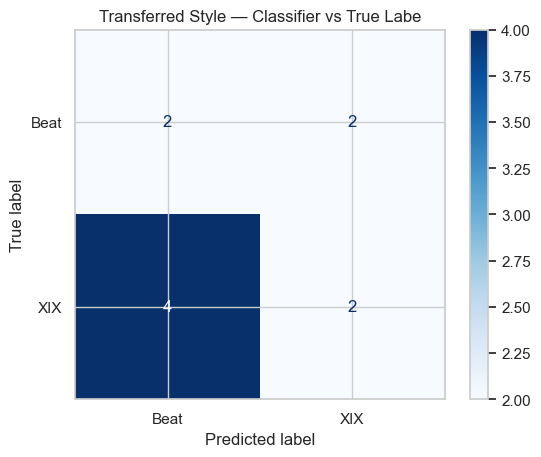


 Style Comparison Table After Transfer
                  author true_style predicted_style
0  TRANSFER_AFTER_01_GPT       Beat             XIX
1  TRANSFER_AFTER_02_GPT        XIX            Beat
2  TRANSFER_AFTER_03_GPT        XIX            Beat
3  TRANSFER_AFTER_04_GPT       Beat            Beat
4  TRANSFER_AFTER_06_GPT        XIX            Beat
5  TRANSFER_AFTER_05_GPT        XIX             XIX
6  TRANSFER_AFTER_07_GPT       Beat            Beat
7  TRANSFER_AFTER_08_GPT       Beat             XIX
8  TRANSFER_AFTER_09_GPT        XIX             XIX
9  TRANSFER_AFTER_10_GPT        XIX            Beat


In [85]:
y_transfer_true = df.loc[mask, "style"].values
y_transfer_pred = y_transfer_pred

cm = confusion_matrix(y_transfer_true, y_transfer_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Transferred Style — Classifier vs True Labe")
plt.show()

print("\n Style Comparison Table After Transfer")
comparison_df = pd.DataFrame({
    "author": df.loc[mask, "author"].values,
    "true_style": y_transfer_true,
    "predicted_style": y_transfer_pred
})
print(comparison_df.head(10))

## Cosine similarity ##

In [86]:
before_indices = []
after_indices = []

for i, row in df.iterrows():
    if row["author"].startswith("TRANSFER_BEFORE_"):
        id_part = row["author"].split("_")[2]  # eg. "01"
        after_label = f"TRANSFER_AFTER_{id_part}_GPT"
        after_rows = df[df["author"] == after_label]

        if not after_rows.empty:
            after_index = after_rows.index[0]
            before_indices.append(i)
            after_indices.append(after_index)

# calculating embedding similarity
before_emb = np.array([embeddings[i] for i in before_indices])
after_emb = np.array([embeddings[i] for i in after_indices])

similarities = cosine_similarity(before_emb, after_emb)
mean_similarity = np.mean(np.diag(similarities))

print(f"\n Cosine similarity: {mean_similarity:.3f}")


 Cosine similarity: 0.804


## Arrow length histograms ##

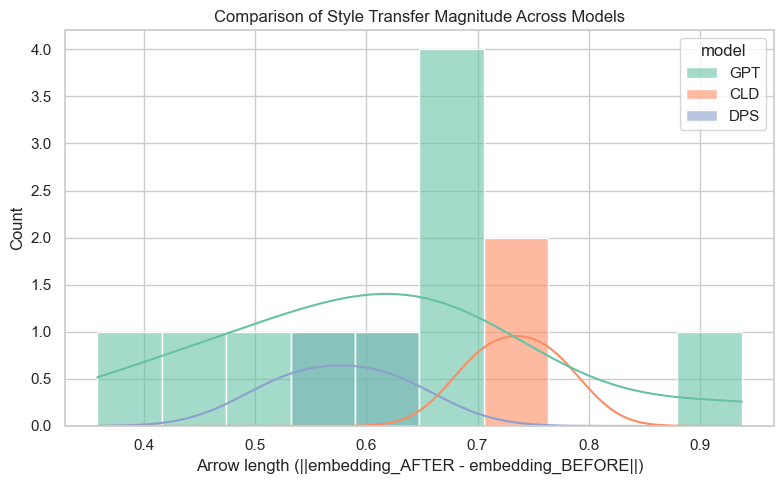

In [87]:
arrow_data = []

for model in ["GPT", "CLD", "DPS"]:
    for i, row in df.iterrows():
        if row["author"].startswith("TRANSFER_BEFORE_"):
            id_part = row["author"].split("_")[2]
            before_label = f"TRANSFER_BEFORE_{id_part}"
            after_label = f"TRANSFER_AFTER_{id_part}_{model}"

            before_rows = df[df["author"] == before_label]
            after_rows = df[df["author"] == after_label]

            if not before_rows.empty and not after_rows.empty:
                before_idx = before_rows.index[0]
                after_idx = after_rows.index[0]

                emb_before = embeddings[before_idx]
                emb_after = embeddings[after_idx]

                length = np.linalg.norm(emb_after - emb_before)
                arrow_data.append({
                    "model": model,
                    "length": length
                })

df_arrows = pd.DataFrame(arrow_data)

plt.figure(figsize=(8, 5))
sns.histplot(data=df_arrows, x="length", hue="model", bins=10, kde=True, palette="Set2", alpha=0.6)

plt.xlabel("Arrow length (||embedding_AFTER - embedding_BEFORE||)")
plt.title("Comparison of Style Transfer Magnitude Across Models")
plt.tight_layout()
plt.show()